<a id="topE"></a>

# Editing the extraction boxes in a spectral extraction file (`XTRACTAB`)

# Learning Goals
<font size="4 "> This Notebook is designed to walk the user (<em>you</em>) through: <b>Altering the extraction box used to extract your spectrum from a COS `TIME-TAG` exposure file.</b></font>

**1. [Investigating the exposure](#invE)**

\- 1.1. [Understanding the `XTRACTAB` and examining a 2D spectrum](#lookE)

\- 1.2. [Defining some useful functions](#funE)

\- 1.3. [Examining the extraction boxes](#boxE)


**2. [Editing the extraction boxes](#editE)**

\- 2.1. [Defining an editing function](#edfnE)

\- 2.2. [Making the edits](#mkedE)

\- 2.3. [Confirming the changes](#confE)
  

**3. [Running the CalCOS Pipeline with the new `XTRACTAB`](#calexE)**

\- 3.1. [Editing the `XTRACTAB` header value](#edhdrE)

\- 3.2. [Running the pipeline](#runcE)


**4. [Example using FUV Data](#fuvE)**


# 0. Introduction
**The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope ([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).**

**This tutorial aims to prepare you to work with the COS data of your choice by walking you through altering the extraction box sizes in the `XTRACTAB`/`_1dx` file to make sure you are extracting the cleanest possible signal from your source and background.** We will demonstrate this in both the NUV and FUV. 

*Note* that some COS modes which use the FUV detector can be better extracted using the [TWOZONE method](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-2-pipeline-processing-overview), which is not directly discussed in this Notebook. All COS/NUV modes use the [BOXCAR method](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-2-pipeline-processing-overview#id-3.2PipelineProcessingOverview-3.2.1OverviewofTWOZONEextraction) discussed in this Notebook.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).


## We will import the following packages:

- `numpy` to handle arrays and functions
- `astropy.io fits` and `astropy.table Table` for accessing FITS files
- `glob`, `os` for working with system files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `matplotlib.pyplot` for plotting
- `matplotlib.image` for reading in images
- `calcos` to run the CalCOS pipeline for COS data reduction
- `scipy.interpolate interp1d` for interpolating datasets to the same sampling
- `pathlib Path` for managing system paths

New versions of `CalCOS` are currently incompatible with astroconda. To create a Python environment capable of running all the data analyses in these COS Notebooks, please see Section 1 of our Notebook tutorial on [setting up an environment](https://github.com/spacetelescope/hst_notebooks/blob/master/notebooks/COS/Setup/Setup.ipynb).

We'll also filter out two unhelpful warnings about a deprecation and dividing by zero which do not affect our data processing.

In [1]:
# Import for array manipulation
import numpy as np

# Import for reading FITS files
from astropy.table import Table
from astropy.io import fits

# Import for downloading the data
from astroquery.mast import Observations

# Import for plotting
from matplotlib import pyplot as plt

# Import for showing images from within Python
from matplotlib import image as mpimg

# Import for dealing with system files
import glob
import os
import shutil

# Import for running the CalCOS pipeline
import calcos

# Import for comparing the old and new CalCOS values
from scipy.interpolate import interp1d 

# Import for working with system paths
from pathlib import Path

# We will also suppress a warning that won't affect our data processing
import warnings
np.seterr(divide='ignore') 
warnings.filterwarnings('ignore',
                        category=np.VisibleDeprecationWarning)

## We will also define a few directories we will need:

In [2]:
# These will be important directories for the notebook
datadir = Path('./data/')
outputdir = Path('./output/')
plotsdir = Path('./output/plots/')

# Make the directories if they don't exist
datadir.mkdir(exist_ok=True)
outputdir.mkdir(exist_ok=True)
plotsdir.mkdir(exist_ok=True)

## And we will need to download the data we wish to work with:
We choose the exposures with the association obs_id: `LE4B04010` and download all the `_rawtag` data. This dataset happens to be COS/NUV data taken with the G185M grating, observing the star: [LS IV -13 30](https://simbad.u-strasbg.fr/simbad/sim-id?Ident=%402582869&Name=LS%20%20IV%20-13%20%20%2030&submit=submit).
For more information on downloading COS data, see our [notebook tutorial on downloading COS data](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/DataDl/DataDl.ipynb).

*Note*, we're working with the `_rawtags` because they are smaller files and quicker to download than the `_corrtag` files. However, this workflow translates very well to using `_corrtag` files, as you likely will want to do when working with your actual data. If you wish to use the default corrections converting from raw to corrected `TIME-TAG` data, you may instead download and work with `CORRTAG` files directly.

In [3]:
# Querying our exposures with the association observation ID LE4B04010
productlist = Observations.get_product_list(Observations.query_criteria(
                                                obs_id='LE4B04010'))

# Getting only the RAWTAG, ASN, and X1DSUM files
masked_productlist = productlist[np.isin(productlist['productSubGroupDescription'], ['RAWTAG', 'ASN', 'X1DSUM'])]

# Now download the files
Observations.download_products(masked_productlist)

Local Path,Status,Message,URL
str50,str8,object,object
./mastDownload/HST/le4b04010/le4b04010_asn.fits,COMPLETE,None,None
./mastDownload/HST/le4b04010/le4b04010_x1dsum.fits,COMPLETE,None,None
./mastDownload/HST/le4b04zfq/le4b04zfq_rawtag.fits,COMPLETE,None,None
./mastDownload/HST/le4b04zkq/le4b04zkq_rawtag.fits,COMPLETE,None,None
./mastDownload/HST/le4b04zoq/le4b04zoq_rawtag.fits,COMPLETE,None,None
./mastDownload/HST/le4b04zqq/le4b04zqq_rawtag.fits,COMPLETE,None,None


We gather a list of all the `_rawtag` files we have downloaded, as well as the `_asnfile` and `_x1dsum` file:

In [4]:
# Getting a list of the RAWTAG, ASN, and X1DSUM files
rawtags = glob.glob('./mastDownload/HST/**/*_rawtag.fits', 
                    recursive=True)

asnfile = glob.glob('./mastDownload/HST/**/*_asn.fits', 
                    recursive=True)[0]

old_x1dsum = glob.glob('./mastDownload/HST/**/*_x1dsum.fits', 
                       recursive=True)[0]

<a id = invE></a>
# 1. Investigating the exposure

<a id = lookE></a>
## 1.1. Understanding the `XTRACTAB` and examining a 2D spectrum
The raw data from the COS instrument is a series of events, each corresponding to a photon interacting with the detector at a specific X, Y point, (*and at a specific time if in `TIME-TAG` mode*). We generally wish to translate this to a 1-dimensional spectrum (***Flux** or Intensity on the y axis vs. **Wavelength** on the x axis*). To do this, we can first make a 2-dimensional spectrum, by plotting all the X and Y points of the spectrum onto a 2D image of the detector. The different spectra (i.e. of the NUV of FUV target, the wavelength calibration source) then appear of stripes of high count density on this image. We can then simply draw extraction boxes around these stripes, and integrate to collapse the data onto the wavelenth axis.

**The `XTRACTAB` is a FITS file which contains a series of parallelogram "boxes" to be used for different COS modes.**

These are the boxes which we collapse to create a 1-dimensional spectrum. For each combination of COS lifetime position, grating, cenwave, etc., the extraction box is specified by giving the slope and y-intercept of a line, and the height of the parallelogram which should be centered on the line. Similar boxes are specified for background regions. For more information on the `XTRACTAB`, see the [COS Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-7-reference-files#id-3.7ReferenceFiles-3.7.12XTRACTAB:1-DSpectralExtractionTablehttps://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-7-reference-files#id-3.7ReferenceFiles-3.7.12XTRACTAB:1-DSpectralExtractionTable).

**For many reasons, we may wish to use an extraction box different from the one specified by the default XTRACTAB, and instead set the boxes manually.**

We need to see where the NUV stripes fall in order to determine where we should place the extraction boxes. First, let's plot this as a 2D image of the raw counts.
To begin, we select and plot the raw counts data from the 0th rawtag file:

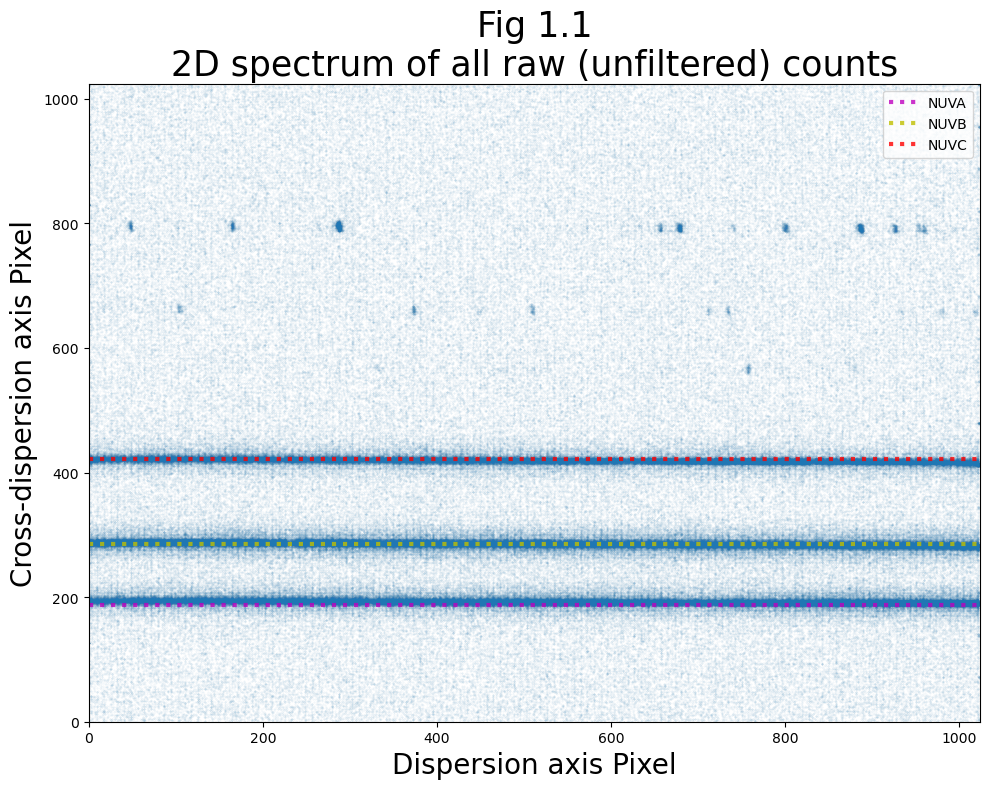

In [5]:
# Read the data from the first rawtag
rawtag = rawtags[0]
rt_data = Table.read(rawtag, 1)

# Setting up the figure
plt.figure(figsize=(10, 8))

# Plot the raw counts
plt.scatter(rt_data['RAWX'], rt_data['RAWY'], 
            # Size of data points
            s=0.1, 
            # Transparency of data points
            alpha=0.1, 
            # Color of data points
            c='C0')

# Plot lines roughly centered on the three NUV stripes (units are pixels)
line = [187, 285, 422]
label = ['NUVA', 'NUVB', 'NUVC']

for i in range(3): 
    plt.axhline(line[i], 
                color='myr'[i],
                linewidth=3, 
                alpha=0.8, 
                linestyle='dotted', 
                label=label[i])

# Setting plot axis limits
plt.xlim(0, 1024)
plt.ylim(0, 1024)

# Adding labels to axes and plot
plt.xlabel('Dispersion axis Pixel', 
           size=20)
plt.ylabel('Cross-dispersion axis Pixel', 
           size=20)
plt.title("Fig 1.1\n2D spectrum of all raw (unfiltered) counts", 
          size=25)

# Adding a legend
plt.legend(loc='upper right')

# Working with plot formatting
plt.tight_layout()

# Showing the plot below
plt.show()

**The dense stripes in the lower half of Fig 1.1 (*highlighted by the dotted lines*) are the actual science data raw counts, while the *patched* stripes towards the top of the plot are the wavelength calibration counts.** For a diagram of a NUV 2D spectrum, see COS Data Handbook [Figure 1.10](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-2-cos-physical-configuration#id-1.2COSPhysicalConfiguration-Figure1.10).

Now we'll need to see where the original `XTRACTAB` places its extraction boxes:

Find the name of the `XTRACTAB` used by this first `_rawtag` file:

In [6]:
orig_xtractab = fits.getheader(rawtag)['XTRACTAB']

### **If you have an existing `lref` directory with a cache of reference files:**
Give the system the `lref` system variable, which points to the reference file directory. Create a cell and run the code below, replacing `<YOUR_EXISTING_LREF_PATH>` with the actual path to your `lref` reference files. 

If you do NOT have an existing `lref variable`, DO NOT do this step. We will setup the reference files used in this notebook in the cell after this one.

```
lref = "YOUR_EXISTING_LREF_PATH"
%env lref YOUR_EXISTING_LREF_PATH

orig_xtractab = lref + orig_xtractab.split('$')[1]
```

### **If you DO NOT have an existing `lref` directory with a cache of reference files:**

If you do not have an existing `lref` directory, then we will create one now. Run the cells below to create your `lref` directory. This directory will point to the reference files that are used for COS data processing. We can see the most recent files on the [HST CRDS website](https://hst-crds.stsci.edu/).

Please check out our [Setup notebook](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/Setup/Setup.ipynb), as it explains in-depth details about the CRDS website and `lref` specifics.

In [7]:
# Getting your home environment
home_dir = os.environ["HOME"]
# Then we will set the CRDS_PATH environment_variable
# Creating path to where the files are saved
crds_path = os.path.join(home_dir, "crds_cache")
# Setting the environment variable CRDS_PATH to our CRDS path
os.environ["CRDS_PATH"] = crds_path

# Set the CRDS_SERVER_URL environment_variable:
# URL for the STScI CRDS page
crds_server_url = "https://hst-crds.stsci.edu"
# Setting env variable to URL
os.environ["CRDS_SERVER_URL"] = crds_server_url

We can now sync the files we need by running the command in the cell below.

**NOTE:** The `context number` (last four digits of `hst_cos_CONTEXTNUM.imap`) will likely have changed by the time this notebook is published. You will want to check that you have the most up-to-date context number by going to the [HST CRDS website](https://hst-crds.stsci.edu/) and clicking the dropdown for COS.

In [8]:
!crds sync --contexts hst_cos_0348.imap --fetch-references

CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  0 infos


In [9]:
# Set the lref environment variable
lref = os.path.join(crds_path, "references/hst/cos/")
os.environ["lref"] = lref

orig_xtractab= lref + orig_xtractab.split('$')[1]


<a id = funE></a>
## 1.2. Defining some useful functions

We'll define a few functions to:
- Read in the data rows containing relevant extraction boxes from an `XTRACTAB` file
- Plot these extraction boxes over a spectrum 
  + *For clarity and signal to noise, we'll collapse this spectrum onto the y (cross-dispersion) axis*

**First, we'll write a function to read in the relavent extraction boxes from an `XTRACTAB`:**

In [10]:
def readxtractab(xtractab, grat, cw, aper):
    """
    Reads in an XTRACTAB row of a particular COS mode and
    returns extraction box sizes and locations.

    Inputs:
    xtractab (str) : path to XTRACTAB file.
    raw (bool) : default False, meaning that the data is assumed to be corrtag.
    grat (string) : grating of relavent row (i.e. "G185M")
    cw (int or numerical) : cenwave of relavent row (i.e. (1786))
    aper (str) : aperture of relavent row (i.e. "PSA")

    Returns:
    y locations of bottoms/tops of extraction boxes
        if NUV: stripe NUVA/B/C, and 2 background boxes
        elif FUV: FUVA/B, and 2 background boxes for each FUVA/B.
    """
    # Read the XTRACTAB FITS data
    with fits.open(xtractab) as f:
        xtrdata = f[1].data 
    
    # Check if the detector is the FUV or NUV detector
    isFUV = fits.getheader(xtractab)['DETECTOR'] == 'FUV'
    
    # If it's the NUV detector, then:
    if not isFUV:
        # Find NUVA of the right row
        sel_nuva = np.where((xtrdata['segment'] == 'NUVA') & 
                            (xtrdata['aperture'] == aper) & 
                            (xtrdata['opt_elem'] == grat) &
                            (xtrdata['cenwave'] == cw))
        
        # Now NUVB
        sel_nuvb = np.where((xtrdata['segment'] == 'NUVB') & 
                            (xtrdata['aperture'] == aper) &
                            (xtrdata['opt_elem'] == grat) &
                            (xtrdata['cenwave'] == cw))
        
        # Now NUVC
        sel_nuvc = np.where((xtrdata['segment'] == 'NUVC') & 
                            (xtrdata['aperture'] == aper) &
                            (xtrdata['opt_elem'] == grat) &
                            (xtrdata['cenwave'] == cw))

        # Find heights of the spec extract boxes
        hgta = xtrdata['HEIGHT'][sel_nuva][0] 
        hgtb = xtrdata['HEIGHT'][sel_nuvb][0] 
        hgtc = xtrdata['HEIGHT'][sel_nuvc][0]

        # Get the y-intercept (b) of the spec
        bspeca = xtrdata['B_SPEC'][sel_nuva][0] 
        bspecb = xtrdata['B_SPEC'][sel_nuvb][0] 
        bspecc = xtrdata['B_SPEC'][sel_nuvc][0]

        # Determine the y bounds of boxes 
        boundsa = [bspeca - hgta/2, bspeca + hgta/2] 
        boundsb = [bspecb - hgtb/2, bspecb + hgtb/2]
        boundsc = [bspecc - hgtc/2, bspecc + hgtc/2]

        # Do the same for the bkg extract boxes
        bkg1a = xtrdata['B_BKG1'][sel_nuva] 
        bkg2a = xtrdata['B_BKG2'][sel_nuva]
        bhgta = xtrdata['BHEIGHT'][sel_nuva]

        bkg1boundsa = [bkg1a - bhgta/2, bkg1a + bhgta/2]
        bkg2boundsa = [bkg2a - bhgta/2, bkg2a + bhgta/2]

        # The background locations are by default the same for all stripes
        return boundsa, boundsb, boundsc, bkg1boundsa, bkg2boundsa
    
    # If it's the FUV detector, then:
    elif isFUV: 
        # Find FUVA of the right row
        sel_fuva = np.where((xtrdata['segment'] == 'FUVA') & 
                            (xtrdata['aperture'] == aper) &  
                            (xtrdata['opt_elem'] == grat) &
                            (xtrdata['cenwave'] == cw))

        # Now FUVB
        sel_fuvb = np.where((xtrdata['segment'] == 'FUVB') & 
                            (xtrdata['aperture'] == aper) &
                            (xtrdata['opt_elem'] == grat) &
                            (xtrdata['cenwave'] == cw))
        
        # Find heights of the spec extract boxes
        hgta = xtrdata['HEIGHT'][sel_fuva][0] 
        hgtb = xtrdata['HEIGHT'][sel_fuvb][0] 

        # Get the y-intercept (b) of the spec boxes
        bspeca = xtrdata['B_SPEC'][sel_fuva][0] 
        bspecb = xtrdata['B_SPEC'][sel_fuvb][0] 

        # Determine the y bounds of the boxes 
        boundsa = [bspeca - hgta/2, bspeca + hgta/2] 
        boundsb = [bspecb - hgtb/2, bspecb + hgtb/2]

        # Do the same for the bkg extract boxes
        bkg1a = xtrdata['B_BKG1'][sel_fuva] 
        bkg2a = xtrdata['B_BKG2'][sel_fuva]
        bhgt1a = xtrdata['B_HGT1'][sel_fuva]
        bhgt2a = xtrdata['B_HGT2'][sel_fuva]

        # Determine the y bounds of the bkg extract boxes
        bkg1boundsa = [bkg1a - bhgt1a/2, bkg1a + bhgt1a/2]
        bkg2boundsa = [bkg2a - bhgt2a/2, bkg2a + bhgt2a/2]
        
        bkg1b = xtrdata['B_BKG1'][sel_fuvb]
        bkg2b = xtrdata['B_BKG2'][sel_fuvb]
        bhgt1b = xtrdata['B_HGT1'][sel_fuvb]
        bhgt2b = xtrdata['B_HGT2'][sel_fuvb]

        bkg1boundsb = [bkg1b - bhgt1b/2, bkg1b + bhgt1b/2]
        bkg2boundsb = [bkg2b - bhgt2b/2, bkg2b + bhgt2b/2]

        return boundsa, boundsb, bkg1boundsa, bkg2boundsa, bkg1boundsb, bkg2boundsb

In [11]:
# We'll note the returned values correspond to these extraction boxes
box_names = ['NUVA', 'NUVB', 'NUVC', 'BKG-1', 'BKG-2']
box_names_fuv = ['FUVA', 'FUVB', 'BKG-1A', 'BKG-2A', 'BKG-1B', 'BKG-2B']

**We'll now need two functions in order to plot.**

The first function: `makeims()` is a helper function for the second: `collapsey()`.

The second function: `collapsey()` takes a list of either `_rawtag` or `_corrtag` exposure files, as well as an `XTRACTAB` file, and creates a summary plot, with the 2D spectrum collapsed onto the y-axis.

In [12]:
def makeims(xarr, yarr):
    """
    Helper function for collapsey(): converts list of counts to image.
    """
    # Size of the new image we will create
    new_img = np.zeros((1024, 1024))
 
    xbin = np.asarray(np.floor((xarr + 0.5)), 
                      dtype=int)
    ybin = np.asarray(np.floor((yarr + 0.5)), 
                      dtype=int)

    # Add a count for each x, y pair
    for x, y in zip(xbin, ybin):
        try:
            new_img[y, x] += 1

        except IndexError:
            continue

    return new_img

**Define the "collapse on y axis" function**

In [13]:
# collapsey() assumes corrtag, but will work with rawtag if raw=True
def collapsey(tagfiles, xtractab, raw=False, save=True, savename=False, display=True, fignum=False):
    """
    Takes a corrtag (default) or RAWTAG and makes a plot of the 2D spectrum collapsed to the y axis
    i.e. summed over rows of pixels along the dispersion direction
    then it overplots the extraction regions from a provided XTRACTAB.
    The behavior is the same for CORRTAG/RAWTAG, only the data columns differ.
    
    Inputs:
    tagfiles (list of str) : List of RAWTAG or CORRTAG file paths.
    xtractab (str) : Path to XTRACTAB.
    raw (bool) : Default False, meaning that the data is assumed to be CORRTAG.
    save (bool) : Do you want to save the image of the plot? Default True
    savename (str if specified) : Name to save file as in plotsdir, if save == True.
    display (bool) : Display the image? Default True.
    fignum  (str if specified) : Figure number to include in figtitle. Dafault is False.
    
    Outputs:
    yprof (numpy array of floats) : the 2D spectrum collapsed onto the y axis.
    """
    # Setting up the figure
    plt.figure(figsize=(12, 8))

    # Go through all the tag files
    for numfile, myfile in enumerate(tagfiles): 
        # Read data from the file
        with fits.open(myfile) as f: 
            data = f[1].data
            h0 = f[0].header

        # Find important header keys to determine row
        fppos = h0['FPPOS'] 
        rootname = h0['ROOTNAME']
        target = h0['TARGNAME']
        grating = h0['OPT_ELEM']
        cenwave = h0['CENWAVE']
        
        # Select corrected or raw time-tag points x and y locations
        if not raw: 
            xcorr = data['XCORR']
            ycorr = data['YCORR']

        elif raw:
            rawx = data['RAWX']
            rawy = data['RAWY']
        
        # Call the helper function on timetag data
        if raw: 
            nuvim = makeims(rawx, rawy)
        else:
            nuvim = makeims(xcorr, ycorr)

        # Collapse onto the y axis
        yprof = np.sum(nuvim, 
                       axis=1) 

        # Make the main y-axis spectrum plot
        yaxis = np.arange(0, 1024)

        # Plot the newly collapsed spectrum plot
        plt.plot(yprof, yaxis, 
                 label=f'{rootname} fppos={fppos}')

        # Add in the plot formatting/titles
        if numfile == 0: 
            if raw:
                plt.ylabel('RAWY Pixel', 
                           size=18)
            else:
                plt.ylabel('YCORR Pixel', 
                           size=18)

            plt.xlabel('Counts summed along X', 
                       size=18)
            
            fig_title = f"Target: {target} spectrum;" + "\n"+f"XTRACTAB: {os.path.basename(xtractab)}"

            if fignum:
                fig_title = f"Fig {fignum}" + "\n" + fig_title

            plt.title(fig_title, 
                      fontsize=23)

            # Get the extraction box sizes and locations for the science and wavecal apertures
            psaboundsa, psaboundsb, psaboundsc, psabkg1, psabkg2 = readxtractab(xtractab, grating, cenwave, 'PSA')
            wcaboundsa, wcaboundsb, wcaboundsc, wcabkg1, wcabkg2 = readxtractab(xtractab, grating, cenwave, 'WCA')

            # Adding shading to show the PSA/WCA regions on the image
            plt.axhspan(psaboundsa[0], psaboundsa[1],
                        # Color of shaded region
                        color='m', 
                        # Label
                        label='PSA Regions', 
                        # Transparency
                        alpha=0.15)
            
            plt.axhspan(psaboundsb[0], psaboundsb[1], 
                        color='m', 
                        alpha=0.15)
            
            plt.axhspan(psaboundsc[0], psaboundsc[1], 
                        color='m', 
                        alpha=0.15)

            plt.axhspan(wcaboundsa[0], wcaboundsa[1],
                        color='blue', 
                        label='WCA regions', 
                        alpha=0.15)

            plt.axhspan(wcaboundsb[0], wcaboundsb[1], 
                        color='blue', 
                        alpha=0.15)

            plt.axhspan(wcaboundsc[0], wcaboundsc[1], 
                        color='blue', 
                        alpha=0.15)
    
    # Add a legend
    plt.legend(loc='upper right')
    
    # More formatting
    plt.tight_layout()
    
    # Saving the figure
    if save:
        # Save in the default manner
        if not savename: 
            plt.savefig(str(plotsdir / f"{target}_regions.png"), 
                        dpi=200, 
                        bbox_inches='tight')

        # Save with input savename
        elif savename: 
            plt.savefig(str(plotsdir / f"{savename}.png"), 
                        dpi=200, 
                        bbox_inches='tight')
            
    # If specified, show the image
    if display:
        plt.show()

    plt.close()
    
    plt.clf()
    
    return yprof

<a id = boxE></a>
## 1.3. Examining the extraction boxes

Now let's make a plot showing where these original `XTRACTAB` boxes fall on the raw count image:

*It's important to note that each extraction box also has a slope associated with it.* This slope is generally very small, and we will not plot the boxes with their slopes while determining the box centers and heights. However, for the purposes of actual extractions, these slopes should be incorporated to determine final extraction bounds.

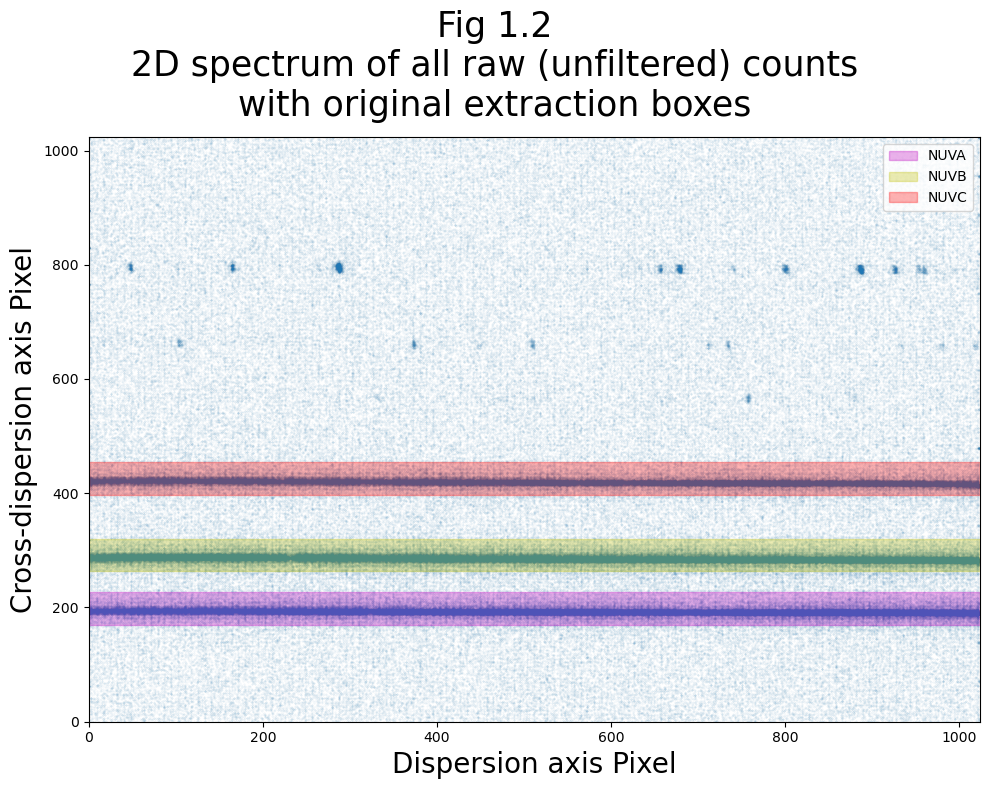

In [14]:
# Bounds of all boxes for these conditions
read_bounds = readxtractab(orig_xtractab, 
                           grat='G185M', 
                           cw=1786, 
                           aper='PSA') 

# Set up figure
plt.figure(figsize=(10, 8)) 

# Image of the raw counts
plt.scatter(rt_data['RAWX'], rt_data['RAWY'], 
            s=0.1, 
            alpha=0.1, 
            c='C0')

# Add all boxes
for i in range(3):
    plt.axhspan(read_bounds[i][0], read_bounds[i][1],
                color="myr"[i],
                alpha=0.3,
                label=box_names[i])

# Add a legend to the plot
plt.legend(loc='upper right') 

# Add x and y axis ranges
plt.xlim(0, 1024)
plt.ylim(0, 1024)

# Add labels and titles
plt.xlabel('Dispersion axis Pixel', 
           size=20)
plt.ylabel('Cross-dispersion axis Pixel', 
           size=20)
plt.suptitle("Fig 1.2\n2D spectrum of all raw (unfiltered) counts\n" +
             "with original extraction boxes", 
             size=25)

# Work with formatting
plt.tight_layout()

# Save figure to our plots directory
plt.savefig(str(plotsdir / '2D_spec_orig_boxes.png'), 
            dpi=200, 
            bbox_inches='tight')

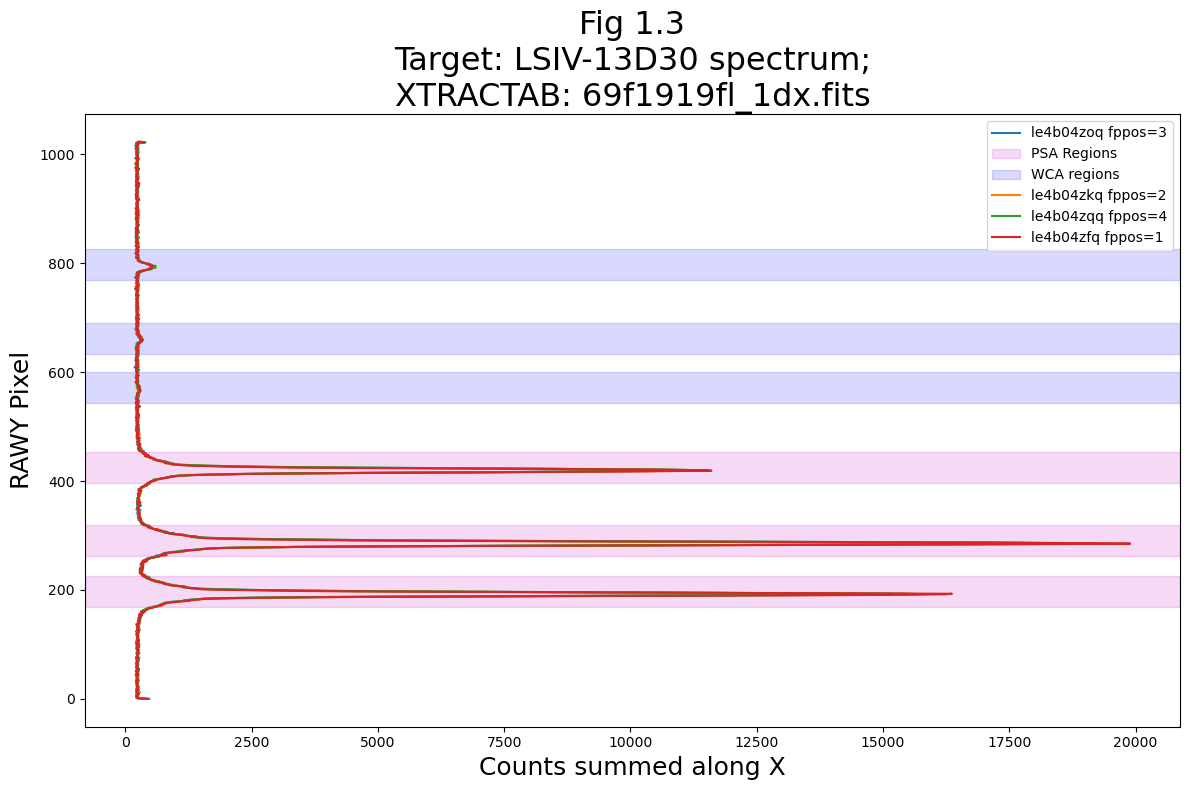

<Figure size 640x480 with 0 Axes>

In [15]:
# Run the function to plot the original boxes over the y-axis spectrum
flat_yspec = collapsey(tagfiles=rawtags, 
                       xtractab=orig_xtractab, 
                       raw=True,
                       save=True, 
                       savename="orig_xtractab_col_y", 
                       fignum="1.3")

<a id = editE></a>
# 2. Editing the extraction boxes

Now that we know how to show the location of the extraction boxes, we can begin actually editing the `XTRACTAB` file.

We'll define another function to edit the existing `XTRACTAB` and save to a new file:

<a id = edfnE></a>
## 2.1. Defining an editing function

In [16]:
def edit_xtractab(xtractab, gratlist, cwlist, h_dict, b_dict, new_filename):
    """
    Function to actually edit the XTRACTAB itself.
    Change the height and y-intercepts of the extraction boxes,
    and save to new XTRACTAB (1dx) file.

    Inputs:
    xtractab (str) : path to the XTRACTAB to edit
    gratlist (list of str) : all the gratings whose rows you would like to edit
    cwlist (list of str) : all the cenwave whose rows you would like to edit
    h_dict (dict of numerical) : heights of NUV A,B,C extraction boxes. Should be ODD!
    b_dict (dict) : dict of the y-intercepts - i.e. box center locations
    new_filename : filename/local path to new XTRACTAB file to create
    """
    # Opening the XTRACTAB file and getting its data
    f = fits.open(xtractab)
    xtrdata = f[1].data

    # Is it FUV or NUV?
    isFUV = fits.getheader(xtractab)['DETECTOR'] == 'FUV'
    
    # Print warning if even height is specified
    for height in h_dict: 
        if h_dict[height] % 2 == 0:
            print("WARNING " + f"Height of {height} is currently even ({h_dict[height]}), but " +
                  "should be ODD. Allowed change, but unadvised.")
    
    # Going through all gratings that you wish to edit
    for grat in gratlist:
        # Going through all cenwaves that you wish to edit
        for cw in cwlist:
            # For NUV data, changing all three gratings and cenwaves
            if not isFUV: 

                sel_nuva = np.where((xtrdata['segment'] == 'NUVA') &
                                    (xtrdata['aperture'] == 'PSA') &
                                    (xtrdata['opt_elem'] == grat) &
                                    (xtrdata['cenwave'] == cw))

                sel_nuvb = np.where((xtrdata['segment'] == 'NUVB') &
                                    (xtrdata['aperture'] == 'PSA') &
                                    (xtrdata['opt_elem'] == grat) &
                                    (xtrdata['cenwave'] == cw))

                sel_nuvc = np.where((xtrdata['segment'] == 'NUVC') &
                                    (xtrdata['aperture'] == 'PSA') &
                                    (xtrdata['opt_elem'] == grat) &
                                    (xtrdata['cenwave'] == cw))

                # Change the background region locations:
                xtrdata['B_BKG1'][sel_nuva] = b_dict['bbkg1']
                xtrdata['B_BKG2'][sel_nuva] = b_dict['bbkg2']

                xtrdata['B_BKG1'][sel_nuvb] = b_dict['bbkg1']
                xtrdata['B_BKG2'][sel_nuvb] = b_dict['bbkg2']

                xtrdata['B_BKG1'][sel_nuvc] = b_dict['bbkg1']
                xtrdata['B_BKG2'][sel_nuvc] = b_dict['bbkg2']

                # Change the extraction heights
                xtrdata['HEIGHT'][sel_nuva] = h_dict['h_a']
                xtrdata['HEIGHT'][sel_nuvb] = h_dict['h_b']
                xtrdata['HEIGHT'][sel_nuvc] = h_dict['h_c']

                # Change the B_SPEC
                xtrdata['B_SPEC'][sel_nuva] = b_dict['bspa']
                xtrdata['B_SPEC'][sel_nuvb] = b_dict['bspb']
                xtrdata['B_SPEC'][sel_nuvc] = b_dict['bspc']
                
            # For FUV data
            elif isFUV: 
                sel_fuva = np.where((xtrdata['segment'] == 'FUVA') &
                                    (xtrdata['aperture'] == 'PSA') &
                                    (xtrdata['opt_elem'] == grat) &
                                    (xtrdata['cenwave'] == cw))

                sel_fuvb = np.where((xtrdata['segment'] == 'FUVB') &
                                    (xtrdata['aperture'] == 'PSA') &
                                    (xtrdata['opt_elem'] == grat) &
                                    (xtrdata['cenwave'] == cw))
                
                # Change the background region locations:
                xtrdata['B_BKG1'][sel_fuva] = b_dict['bbkg1a']
                xtrdata['B_BKG2'][sel_fuva] = b_dict['bbkg2a']
                
                xtrdata['B_BKG1'][sel_fuvb] = b_dict['bbkg1b']
                xtrdata['B_BKG2'][sel_fuvb] = b_dict['bbkg2b']
                # Change the extraction heights
                xtrdata['HEIGHT'][sel_fuva] = h_dict['h_a']
                xtrdata['HEIGHT'][sel_fuvb] = h_dict['h_b']
                # Change the B_SPEC
                xtrdata['B_SPEC'][sel_fuva] = b_dict['bspa']
                xtrdata['B_SPEC'][sel_fuvb] = b_dict['bspb']
                
    # Save and close the file
    f.writeto(new_filename, 
              overwrite=True)

    f.close()

    return

<a id = mkedE></a>
## 2.2. Making the edits

Now we'll edit the `XTRACTAB` file to have different sizes and locations of the extraction boxes using `edit_xtractab()`.

For the purposes of this example, we'll **arbitrarily** set our y-intercepts and heights, just trying to roughly cover the NUV stripes, and show the different heights we can set the boxes to. *Note* that this function does not stop us from setting the boxes to overlap - but, dependent on your data, this may be a bad idea. 

The scope of this Notebook is merely to explain *how* to alter the extraction boxes, not to determine the best box locations for any given dataset. While we cannot give specific rules to fit every single dataset, the general rules suggest you: 

* Define spectral extraction boxes which contain as much flux from the target as possible while including very little of the background region.

* Define background extraction boxes as close to your target as possible without the possibility of overlap.

* Avoid detector hotspots and regions of poor sensitivity.

* Box heights should be odd, so that there is a central pixel.

First we'll set up the values to which we'll edit the box parameters, and then run the function on the original XTRACTAB to change our G185M extraction boxes in the rows for cenwaves 1786 and 1817:

In [17]:
# The values we set the box params to:
# Centers of the background extract regions
intercept_dict = {"bbkg1": 900., "bbkg2": 60., 
                  # Centers of NUV stripe extract regions
                  'bspa': 195., 'bspb': 285., 'bspc': 415.} 

hgt_dict = {'h_a': 41, 'h_b': 51, 'h_c': 61}

# Now edit using the edit_xtractab() function;
# We'll change G185M grating for cenwaves 1786, 1817:
edit_xtractab(xtractab=orig_xtractab, 
              # We're changing the G185M grating
              gratlist=['G185M'], 
              # We're changing the 1786 and 1817 cenwaves for this grating
              cwlist=[1786, 1817], 
              # New (arbitrary) heights to set boxes to
              h_dict=hgt_dict, 
              # New y-intercepts for boxes
              b_dict=intercept_dict, 
              new_filename='./edit_1dx.fits') 

<a id = confE></a>
## 2.3. Confirming the changes

**Now we plot the old and new extraction boxes side-by-side to compare:**

In [18]:
# Set up the plot, we're going to have 2 subplots
fig, (ax0, ax1) = plt.subplots(1, 2, 
                               figsize=(14, 8), 
                               sharey=True)

# Add raw count images to both subplots
ax0.scatter(rt_data['RAWX'], rt_data['RAWY'], 
            s=0.1, 
            alpha=0.1, 
            c='C0')

ax1.scatter(rt_data['RAWX'], rt_data['RAWY'], 
            s=0.1, 
            alpha=0.1, 
            c='C0')

# First plot the boxes from the original XTRACTAB 
read_bounds_old = readxtractab(orig_xtractab, 
                               grat='G185M', 
                               cw=1786, 
                               aper='PSA')

for i in range(3):
    ax0.axhspan(read_bounds_old[i][0], read_bounds_old[i][1],
                color="myr"[i],
                alpha=0.3,
                label=box_names[i]+"_old")

# Hatches will help differentiate between the old and new boxes
plt.rcParams['hatch.linewidth'] = 1

# Now with the newly edited XTRACTAB
read_bounds_new = readxtractab('./edit_1dx.fits', 
                               grat='G185M', 
                               cw=1786, 
                               aper='PSA')
  
for i in range(3):
    ax1.axhspan(read_bounds_new[i][0], read_bounds_new[i][1],
                color="myr"[i],
                alpha=0.3,
                # Specifying the hatch
                hatch="x*",
                label=box_names[i]+"_new")

# Now some plot formatting
ax0.legend(loc='upper right')
ax1.legend(loc='upper right')

ax0.set_xlim(0, 1024)
ax0.set_ylim(0, 1024)
ax1.set_xlim(ax0.get_xlim())

fig.text(0.42, -0.01,
         'Dispersion axis Pixel', 
         size=20)
ax0.set_ylabel('Cross-dispersion axis Pixel', 
               size=20)
plt.suptitle("Fig 2.1\n2D spectrum of all raw (unfiltered) counts\n" +
             "with original ($left$) and new ($right$) extraction boxes", 
             size=25)

plt.tight_layout()

plt.savefig(str(plotsdir / '2D_spec_both_box_sets.png'), 
            dpi=200, 
            bbox_inches='tight')

**We'll also make a plot of the new boxes over the spectrum collapsed onto the y-axis, and we'll plot it side-by-side with Fig 1.3, which shows the original extraction boxes:**

In [ ]:
# Run the function to plot the original boxes over the y-axis spectrum
flat_yspec = collapsey(tagfiles=rawtags, 
                       xtractab='./edit_1dx.fits', 
                       raw=True,
                       save=True, 
                       display=False, 
                       savename="edit_xtractab_col_y", 
                       fignum="2.2")

# Now plot both together
fig, (ax0, ax1) = plt.subplots(1, 2,
                               figsize=(25, 18))

ax0.imshow(mpimg.imread('./output/plots/orig_xtractab_col_y.png'))
ax1.imshow(mpimg.imread('./output/plots/edit_xtractab_col_y.png'))

ax0.axis('off')
ax1.axis('off')

plt.tight_layout()

plt.show()

<a id = calexE></a>
# 3. Running the CalCOS Pipeline with the new `XTRACTAB`

<a id = edhdrE></a>
## 3.1. Editing the `XTRACTAB` header value
More detailed information on changing header parameters can be found in our [walkthrough Notebook on `CalCOS`](https://github.com/spacetelescope/hst_notebooks/blob/master/notebooks/COS/CalCOS/CalCOS.ipynb).

Here, we just need to tell the pipeline to use our newly edited `XTRACTAB`. We do this by editing one of the header key values in all of the affected files.

In [ ]:
try: 
    for rawtag in rawtags:
        os.rename(rawtag, datadir / os.path.basename(rawtag))
except FileNotFoundError:
    print('No files')

try: 
    os.rename(asnfile, datadir / os.path.basename(asnfile))
except FileNotFoundError:
    print('No files')
    
rawtags = glob.glob(str(datadir / '*rawtag*'))
asnfile = glob.glob(str(datadir / '*asn*'))[0]

In [ ]:
for rawtag in rawtags:
    print("changing XTRACTAB for ", os.path.basename(rawtag))
    print("\tOriginally: ", fits.getheader(rawtag)['XTRACTAB'])

    fits.setval(filename=rawtag, 
                keyword='XTRACTAB', 
                value='./edit_1dx.fits')
    
    print("\tNow set to: ", fits.getheader(rawtag)['XTRACTAB'])

<a id = runcE></a>
## 3.2. Running the pipeline
We will also largely gloss over the details of running the pipeline, `CalCOS`, in this Notebook. Once again, much more detailed information on running the `CalCOS` pipeline can be found in our [walkthrough Notebook on using `CalCOS`](https://github.com/spacetelescope/hst_notebooks/blob/master/notebooks/COS/CalCOS/CalCOS.ipynb).

**If you don't have an `lref` directory with all your COS reference files, the following cells will fail to run** and you should see our tutorial on [Setting up an environment to work with COS data](https://github.com/spacetelescope/hst_notebooks/blob/master/hst_notebooks/COS/Setup/Setup.ipynb).

Note too that if you've already run calcos in this cell, it will fail to run again unless you clear the directory that the products are in.

In [ ]:
%%capture cap --no-stderr 
# Above ^ capture the output and save it in the next cell

# Checking if there's output already
if os.path.exists(outputdir / "calcos_run1"):
    shutil.rmtree(outputdir / "calcos_run1")

# This line actually runs the pipeline:
calcos.calcos(asnfile, 
              verbosity=1, 
              outdir=str(outputdir / "calcos_run1"))

This file now contains the output of the last cell:

In [ ]:
with open(str(outputdir/'output_calcos_1.txt'), 'w') as f: 
    f.write(cap.stdout)

**We'll finish up by plotting the new and original `x1dsum` spectra as extracted with the new and original extraction boxes:**

*Note* that we can ignore the UnitsWarning.

In [ ]:
# Set up figure:
fig = plt.figure(figsize=(20, 7))

# Using gridspec to control panel sizes and locations
gs = fig.add_gridspec(nrows=5, 
                      ncols=3) 

# Going through each NUV stripe
for i in range(3):
    # Creating two subplots, one with the X1DSUM data and the other a residual plot
    ax0 = fig.add_subplot(gs[0:4, i])
    ax1 = fig.add_subplot(gs[4:5, i])

    # Getting the newly created (edited) X1DSUM's data
    new_wvln, new_flux = Table.read('./output/calcos_run1/le4b04010_x1dsum.fits')[i]['WAVELENGTH', 'FLUX']
    # Getting the old X1DSUM's data
    old_wvln, old_flux, seg = Table.read(old_x1dsum)[i]['WAVELENGTH', 'FLUX', 'SEGMENT']
    
    # Interpolate the new wvln onto the old wvln's sampling:
    new_flux_interp = interp1d(x=new_wvln, y=new_flux, 
                               fill_value="extrapolate")(old_wvln)

    # Print max difference to user:
    print(f"Stripe {seg} differs by up to: \
    {100 * max(new_flux - old_flux)/np.mean(abs(old_flux)):.3f}%")

    # Plotting upper panel
    ax0.plot(new_wvln, new_flux, 
             linewidth=0.5, 
             label='$New$ extracted spectrum')
    ax0.plot(old_wvln, old_flux, 
             linewidth=0.5, 
             label='$Original$ extracted spectrum')

    # Plotting lower panel
    ax1.plot(new_wvln, old_flux - new_flux_interp, 
             linewidth=0.5, 
             label='Residual')

    # Formatting:
    ax0.set_title(f"Segment {seg}", 
                  fontsize=20)

    ax0.set_xticks([])

    # Adding a legend
    ax0.legend(loc='lower center')
    ax1.legend(loc='lower center')

    # Add axis labels to the plot
    if i == 0: 
        ax0.set_ylabel(r"Flux\n[$erg\ \AA^{-1}\ cm^{-2}\ s^{-1}$]", 
                       fontsize=20)
    if i == 1:
        plt.xlabel("Wavelength", 
                   fontsize=20)

plt.suptitle("Fig 3.1\nComparing the old and new extracted spectra for each segment", 
             fontsize=25)

# More formatting
plt.tight_layout()

# Save the figure
plt.savefig(str(plotsdir / "comp_extracted.png"), 
            dpi=200)

<a id = fuvE></a>
# 4. Example using FUV data

Let's go through doing all of the above with an FUV dataset and corresponding FUV `XTRACTAB`.

First download the FUV data; we'll select an FUV/G160M/C1533 dataset from the same proposal as the NUV dataset.

In [ ]:
# Querying the PID's data
pl = Observations.get_product_list(
                        Observations.query_criteria(
                            proposal_id=15869, 
                            obs_id='LE4B01040'))

# Getting only the RAWTAG, ASN, and X1DSUM files
masked_pl = pl[np.isin(pl['productSubGroupDescription'], ['RAWTAG_A', 'RAWTAG_B', 'ASN', 'X1DSUM'])]

# Now download the files
Observations.download_products(masked_pl)

**We gather a list of all the `_rawtag` files we have downloaded, as well as the `_asnfile` and `_x1dsum` file:**

In [ ]:
rawtags_a = glob.glob('./mastDownload/HST/le4b01*/**/*_rawtag_a.fits', 
                      recursive=True)

rawtags_b = glob.glob('./mastDownload/HST/le4b01*/**/*_rawtag_b.fits', 
                      recursive=True)

rawtags_ab = rawtags_a + rawtags_b

asnfile = glob.glob('./mastDownload/HST/le4b01040/**/*_asn.fits', 
                    recursive=True)[0]

old_x1dsum = glob.glob('./mastDownload/HST/le4b01040/**/*_x1dsum.fits', 
                       recursive=True)[0]

Move the files and index them again:

In [ ]:
# Aggregate all this FUV data, except the calibrated x1dsum
fdatadir = Path('./fuv_data/') 
fdatadir.mkdir(exist_ok=True)

[os.rename(rta, fdatadir / os.path.basename(rta)) for rta in rawtags_a]
[os.rename(rtb, fdatadir / os.path.basename(rtb)) for rtb in rawtags_b]

os.rename(asnfile, fdatadir / os.path.basename(asnfile))

# Re-find all the data now that it's moved
rawtags_a = glob.glob(str(fdatadir/'*_rawtag_a.fits'), 
                      recursive=True)
rawtags_b = glob.glob(str(fdatadir/'*_rawtag_b.fits'), 
                      recursive=True)

rawtags_ab = rawtags_a + rawtags_b

asnfile = glob.glob(str(fdatadir/'*_asn.fits'), 
                    recursive=True)[0]

**We need to see where the FUV spectra fall in order to determine where we should place the extraction boxes.**

We'll first plot this as a 2D image of the raw counts.
We select and plot the raw counts data from the 0th `rawtag_a` and `rawtag_b` files:

In [ ]:
# Find the data from the first rawtag_a/b file
rtda = Table.read(rawtags_a[0], 1)
rtdb = Table.read(rawtags_b[0], 1)

# Creating our figure
fig, (ax0, ax1) = plt.subplots(1, 2,
                               figsize=(16, 8))

ax0.scatter(rtdb['RAWX'], rtdb['RAWY'], 
            s=0.1, 
            alpha=0.1, 
            c='C0')

ax1.scatter(rtda['RAWX'], rtda['RAWY'], 
            s=0.1, 
            alpha=0.1, 
            c='C0')

ax0.set_title("Segment FUVB", 
              fontsize=20)
ax1.set_title("Segment FUVA", 
              fontsize=20)

ax0.set_xlabel('Dispersion axis Pixel',
               size=20)
ax1.set_xlabel('Dispersion axis Pixel',
               size=20)
ax0.set_ylabel('Cross-dispersion axis Pixel', 
               size=20)
plt.suptitle("Fig 4.1\n2D spectrum of all raw (unfiltered) counts", 
             size=25)

plt.tight_layout()

plt.show()

plt.savefig(str(plotsdir / 'fuv_2Dspectrum.png'), 
            dpi=200)

**We now need to download the correct `XTRACTAB`.**

The next cell tells you what this `XTRACTAB` *should* be, and you download it in the cell that follows. Make sure these filenames match, as the reference files may have changed since this tutorial was created.

In [ ]:
correct_fuv_1dx = fits.getheader(rawtags_a[0])['XTRACTAB'].split("$")[1]

print("Make sure the next line is set to download: ", correct_fuv_1dx)

In [ ]:
! crds sync --files=2bj2256il_1dx.fits

**Now we can plot the original fuv boxes:**

In [ ]:
# Getting our XTRACTAB reference file for the FUV
fuv_xtractab = lref + correct_fuv_1dx

read_bounds = readxtractab(fuv_xtractab, 
                           grat='G160M', 
                           cw=1533, 
                           aper='PSA')

# Setting up a figure with two subplots, top being FUVA and bottom being FUVB
fig, (ax0, ax1) = plt.subplots(2, 1, 
                               figsize=(10, 8), 
                               sharex=True)

# Getting an image of the raw counts (RAWTAG A)
ax1.scatter(rtda['RAWX'], rtda['RAWY'],
            s=0.1, 
            alpha=0.1, 
            c='C0')

# Getting an image of the raw counts (RAWTAG B)
ax0.scatter(rtdb['RAWX'], rtdb['RAWY'], 
            s=0.1, 
            alpha=0.1, 
            c='C0')

# Plotting the boxes for FUVA and FUVB (not background)
for i in range(2):
    # If it's the FUVB box:
    if 'A' not in box_names_fuv[i]:
        ax0.axhspan(read_bounds[i][0], read_bounds[i][1],
                    color='cm'[i],
                    hatch='/+x+x'[i],
                    alpha=0.3,
                    label=box_names_fuv[i])
        
    # If it's the FUVA box
    else:
        ax1.axhspan(read_bounds[i][0], read_bounds[i][1],
                    color='cm'[i],
                    hatch='/+x+x'[i],
                    alpha=0.3,
                    label=box_names_fuv[i])

# Add plot formatting
ax0.legend(loc='upper right') 
ax1.legend(loc='upper right') 

ax0.set_xlim(920, 15450)
ax0.set_ylim(300, 700)
ax1.set_ylim(ax0.get_ylim())

ax1.set_xlabel('Dispersion axis Pixel', 
               size=20)
fig.text(-0.01, 0.2,
         'Cross-dispersion axis Pixel', 
         size=20, 
         rotation='vertical')

plt.suptitle("Fig 4.2\n2D spectrum of all raw (unfiltered) counts\n" +
             "with original extraction boxes in the FUV", 
             size=25)

plt.tight_layout()

# Save the figure to the plots directory
plt.savefig(str(plotsdir / '2D_spec_orig_boxes_fuv.png'), 
            dpi=200, 
            bbox_inches='tight')

**Here we make the edits to the FUV `XTRACTAB`:**

In [ ]:
# These will be the values we set the box params to:
# Centers of the background extract regions
intercept_dict_fuv = {"bbkg1a": 550., "bbkg2a": 340.,
                      "bbkg1b": 350., "bbkg2b": 665.,
                      # Centers of NUV stripe extract regions
                      'bspa': 415., 'bspb': 469.} 

hgt_dict_fuv = {'h_a': 51, 'h_b': 41}

# Now edit using the edit_xtractab() function
edit_xtractab(xtractab=fuv_xtractab, 
              gratlist=['G160M'], 
              cwlist=[1533], 
              h_dict=hgt_dict_fuv, 
              b_dict=intercept_dict_fuv, 
              new_filename='./edit_fuv_1dx.fits')

**We'll create a plot showing the old and new extraction boxes side-by-side:**

In [ ]:
# Original boxes
read_bounds = readxtractab(fuv_xtractab, 
                           grat='G160M', 
                           cw=1533, 
                           aper='PSA') 

# Edited boxes
read_bounds_fuv_edit = readxtractab('./edit_fuv_1dx.fits', 
                                    grat='G160M',
                                    cw=1533, 
                                    aper='PSA') 

# Orig = ax0, ax1; New/Edited = ax2, ax3
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, 
                                             figsize=(20, 10), 
                                             sharex=True, 
                                             sharey=True)

# The original:
# Images of the raw counts:
# RAWTAG A
ax2.scatter(rtda['RAWX'], rtda['RAWY'], 
            s=0.1, 
            alpha=0.1, 
            c='C0')

# RAWTAG B
ax0.scatter(rtdb['RAWX'], rtdb['RAWY'], 
            s=0.1, 
            alpha=0.1, 
            c='C0')

# RAWTAG A
ax3.scatter(rtda['RAWX'], rtda['RAWY'], 
            s=0.1, 
            alpha=0.1, 
            c='C0') 

# RAWTAG B
ax1.scatter(rtdb['RAWX'], rtdb['RAWY'], 
            s=0.1, 
            alpha=0.1, 
            c='C0') 

# Add all the boxes onto each subplots' image
for i, (oldbox, newbox, bname) in enumerate(zip(read_bounds[:2], read_bounds_fuv_edit[:2], box_names_fuv[:2])):
    # FUVA in ax0, ax1 (top left/right) 
    if 'A' not in bname: 
        ax0.axhspan(oldbox[0], oldbox[1], 
                    color='cmkyky'[i], 
                    hatch='/+x+x'[i], 
                    alpha=0.3, 
                    label=bname)
        ax1.axhspan(newbox[0], newbox[1], 
                    color='cmkyky'[i], 
                    hatch='/+x+x'[i], 
                    alpha=0.3, 
                    label=bname)
        
    # FUVB in ax2, ax3 (bottom left/right)
    else: 
        ax2.axhspan(oldbox[0], oldbox[1], 
                    color='cmkyky'[i], 
                    hatch='/+x+x'[i], 
                    alpha=0.3, 
                    label=bname)
        ax3.axhspan(newbox[0], newbox[1], 
                    color='cmkyky'[i], 
                    hatch='/+x+x'[i], 
                    alpha=0.3, 
                    label=bname)

# Add plot formatting
ax0.legend(loc='upper right') 
ax1.legend(loc='upper right')
ax2.legend(loc='upper right') 
ax3.legend(loc='upper right')

ax0.set_xlim(920, 15450)
ax0.set_ylim(300, 700)

ax1.set_ylim(ax0.get_ylim())

ax0.set_title("Original extraction boxes", 
              fontsize=20)
ax1.set_title("Edited extraction boxes", 
              fontsize=20)

fig.text(-0.01, 0.2, 'Cross-dispersion axis Pixel',
         size=20, 
         rotation='vertical')
fig.text(0.45, -0.01, 'Dispersion axis Pixel', 
         size=20)

plt.suptitle("Fig 4.3\n2D spectrum of all raw (unfiltered) counts\n" +
             "with original and edited extraction boxes in the FUV", 
             size=25)

plt.tight_layout()

# Saving the figure
plt.savefig(str(plotsdir / '2D_spec_origedit_boxes_fuv.png'),
            dpi=200, 
            bbox_inches='tight')

**Before we could run CalCOS on this file with the new `XTRACTAB`, (or *any* `BOXCAR` extraction file, for that matter,) you must change the relevant calibration switches in the file's primary fits header to...**
1. perform a `BOXCAR` extraction
2. use the newly edited `XTRACTAB` file.

We must set the switches as follows in the Table:

|Header Keyword|Possible Values|Value to set in order to apply this `XTRACTAB`|What does it tell CalCOS to do?|
|-|-|-|-|
|`XTRCTALG`|**`BOXCAR`**/`TWOZONE`|`BOXCAR`|Which extraction method to apply|
|`TRCECORR`|`PERFORM`/**`OMIT`**|`OMIT`|Whether to perform or omit the [trace correction](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-4-descriptions-of-spectroscopic-calibration-steps#id-3.4DescriptionsofSpectroscopicCalibrationSteps-3.4.14TRCECORR:ApplyTraceCorrection)|
|`ALGNCORR`|`PERFORM`/**`OMIT`**|`OMIT`|Whether to perform or omit the [align correction](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-4-descriptions-of-spectroscopic-calibration-steps#id-3.4DescriptionsofSpectroscopicCalibrationSteps-3.4.15ALGNCORR:AlignmentCorrection)|
|`XTRACTAB`|Local path to any valid `XTRACTAB` file|./edit_fuv_1dx.fits|Where to find a local copy of the `XTRACTAB` to use|

We set the switches below:

In [ ]:
# Dictionary we'll use to set the values of the header calib switches
fuv_keys_dict = { 
    'XTRCTALG': 'BOXCAR',
    'TRCECORR': 'OMIT',
    'ALGNCORR': 'OMIT',
    'XTRACTAB': './edit_fuv_1dx.fits'}

# Change this to True if you want to see the changes
verbose = False 

# Loop through the rawtag A/B files
for rawtag in rawtags_ab: 
    print("changing header switches for ", os.path.basename(rawtag))
    for fuv_key, fuv_val in fuv_keys_dict.items():
        if verbose:
            print("\tOriginally: ", fuv_key, '=', fits.getheader(rawtag)[fuv_key])

        # Change the value of the FITS file
        fits.setval(filename=rawtag, 
                    keyword=fuv_key, 
                    value=fuv_val)

        if verbose:
            print("\t       Now: ", fuv_key, '=', fits.getheader(rawtag)[fuv_key])

**You may now run `CalCOS` using this new FUV `XTRACTAB`.**

In [ ]:
%%capture cap --no-stderr 
# Above ^ capture the output and save it in the next cell

# Checking if there's output already
if os.path.exists(outputdir / "calcos_fuv_run1"):
    shutil.rmtree(outputdir / "calcos_fuv_run1")

# This line actually runs the pipeline:
calcos.calcos(asnfile, 
              verbosity=1, 
              outdir=str(outputdir / "calcos_fuv_run1"))

In [ ]:
# This file now contains the output of the last cell
with open(str(outputdir/'output_calcos_fuv_1.txt'), 'w') as f: 
    f.write(cap.stdout)

**Now let's compare the FUV spectra extracted with the original and new `XTRACTAB`s:**

*Note* again, that we can ignore the UnitsWarning.

In [ ]:
# Set up figure
fig = plt.figure(figsize=(20, 7))

gs = fig.add_gridspec(nrows=5, 
                      ncols=2) 

# Use i,j to plot FUVA on the right, not the left, by inverting subplot index
for i, j in zip([0, 1], [1, 0]):
    ax0 = fig.add_subplot(gs[0:4, j])
    ax1 = fig.add_subplot(gs[4:5, j])

    # Get the new and old flux/wavelength data to be plotted
    new_wvln, new_flux = Table.read('./output/calcos_fuv_run1/le4b01040_x1dsum.fits')[i]['WAVELENGTH', 'FLUX']
    old_wvln, old_flux, seg = Table.read(old_x1dsum)[i]['WAVELENGTH', 'FLUX', 'SEGMENT']
    
    # Interpolate the new wvln onto the old wvln's sampling:
    new_flux_interp = interp1d(x=new_wvln, y=new_flux, 
                               fill_value="extrapolate")(old_wvln)

    # Print the max difference
    print(f"Stripe {seg} differs by up to: \
    {max(new_flux - old_flux)/np.mean(abs(old_flux)):.3f}%")

    # Plotting the upper panel
    ax0.plot(new_wvln, new_flux,
             alpha=1, 
             linewidth=0.5, 
             c='C1',
             label='$New$ extracted spectrum')
    
    ax0.plot(old_wvln, old_flux, 
             linewidth=1, 
             c='C0',
             linestyle='dotted', 
             alpha=0.75,
             label='$Original$ extracted spectrum')

    # Plotting the lower panel
    ax1.plot(new_wvln, old_flux - new_flux_interp, 
             linewidth=0.5, 
             label='Residual')

    # Some formatting:
    ax0.set_title(f"Segment {seg}", 
                  fontsize=20)

    ax0.set_xticks([])

    ax0.legend(loc='lower center')
    ax1.legend(loc='lower center')

    # Add axis labels to the plot
    if i == 0: 
        ax0.set_ylabel(r"Flux\n[$erg\ \AA^{-1}\ cm^{-2}\ s^{-1}$]", 
                       fontsize=20)
    if i == 1:
        plt.xlabel("Wavelength", 
                   fontsize=20)

plt.suptitle("Fig 4.4\nComparing the old and new extracted spectra for each segment in the FUV", 
             fontsize=25)

plt.tight_layout()

# Saving the figure
plt.savefig(str(plotsdir / "comp_fuv_extracted.png"), 
            dpi=200)

# In conclusion
* We have learned what the `XTRACTAB` file is and how it affects your calibration of COS spectra
* We have learned how to edit your `XTRACTAB` to tailor how `CalCOS` extracts the spectrum of the source and background
* We have shown examples of changing the `XTRACTAB` and reprocessing the data with the altered extraction boxes in both the FUV and NUV

## Congratulations! You finished this Notebook!
### There are more COS data walkthrough Notebooks on different topics. You can find them [here](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/COS).


---
## About this Notebook
**Author:** Nat Kerman <nkerman@stsci.edu>

**Contributors:** Elaine Mae Frazer

**Updated On:** 2023-07-27

> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`](https://docs.astropy.org/en/stable/index.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `matplotlib`](https://matplotlib.org/)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topE)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

<br></br>
<br></br>
<br></br>